In [7]:
import numpy as np
import dicom
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode')
import core
import pylab as plt
import nibabel as nib
import skimage
from skimage.segmentation import find_boundaries as boundaries
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import time
import SimpleITK as sitk

In [17]:
paths = ['/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleB/SB_Pre-op.nrrd',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleC/SC_Pre-op.nrrd',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleD/SD_Pre-op.nrrd',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleF/SF_Pre-op.nrrd',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleG/SG_Pre-op.nrrd',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleH/SH_Pre-op.nrrd',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/SampleI/SI_Pre-op.nrrd']

In [18]:
for pathnumber in range(len(paths)):
    path = paths[pathnumber]
    print 'iteration number', pathnumber

    if path.endswith('.nii') or path.endswith('.nii.gz'):
        array, ConstPixelSpacing, affine = core.nifti2np(path)
        bone = core.thresholdnp(array, 1100, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)

    elif path.endswith('.dcm'):
        array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
#         bone = core.thresholdnp(array, 900, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)

    elif path.endswith('.nrrd'):
        array, ConstPixelSpacing, affine = core.nrrd2np(path)
        array=np.swapaxes(array, 0, 1)
#         bone = core.thresholdnp(array, 1100, 1500)
        softtissue  = core.thresholdnp(array, 0, 80)
    
    skin_mask = array
    skin_mask = np.multiply(skin_mask, (array>-200).astype(int))
    array1 = np.multiply(skin_mask, (skin_mask>0.0).astype(int))
    array1 = np.multiply(array1, (array1>-200).astype(int))
#     skull_mask = array1>84.0
#     array2 = np.multiply(array1, (array1<84.0).astype(int))
    skull_mask = array1>100.0
    array2 = np.multiply(array1, (array1<100.0).astype(int))
    orbital_mask = skull_mask
    for i in range(5):
        orbital_mask = bd(skull_mask)
    array3 = np.multiply(array2, (orbital_mask==False).astype(int))
    array4 = np.multiply(array3, (array3>0.0).astype(int))
    import nipype.interfaces.fsl as fsl

    def extract(thresholded):
        img = nib.Nifti1Image(thresholded, np.eye(4))
        nib.save(img, 'temp.nii.gz')
        img = nib.load('temp.nii.gz')
        mybet = fsl.BET()
        result = mybet.run(in_file='temp.nii.gz', out_file='BET-temp.nii.gz', frac=0.1)
        img = nib.load('BET-temp.nii.gz')
        data = img.get_data()
        return data
    array5 = extract(array4)
    brain_mask = np.multiply(bc(bfh(bd(array5))).astype(int), array5)
    B_mask = (brain_mask!=0).astype(int)
    def saveMask(array, path, name):
        mask = array.astype(np.float64)
        mask = np.swapaxes(mask, 0, 1)
        img = nib.Nifti1Image(mask, affine)
        savePath = os.path.join(os.path.split(path)[0], '{}.nii.gz'.format(name))
        nib.save(img, savePath)
    
    saveMask(B_mask,path,'original')

iteration number 0
iteration number 1
iteration number 2
iteration number 3
iteration number 4
iteration number 5
iteration number 6


In [6]:
if path.endswith('.nii') or path.endswith('.nii.gz'):
    array, ConstPixelSpacing, affine = core.nifti2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

elif path.endswith('.dcm'):
    array, ConstPixelSpacing, origin, path, affine = core.dicom2np(path)
    bone = core.thresholdnp(array, 900, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

elif path.endswith('.nrrd'):
    array, ConstPixelSpacing, affine = core.nrrd2np(path)
    bone = core.thresholdnp(array, 1100, 1500)
    softtissue  = core.thresholdnp(array, 0, 80)

IndexError: list index out of range

# 1. Remove Skin

In [26]:
# scanRange = np.max(array) - np.min(array)
skin_mask = array

# def removeSkin(array):
#     print i
#     filtered = skimage.filters.gaussian(array, sigma=1)
#     thresholded1 = np.multiply(filtered, array)
#     thresholded2 = np.multiply(array, (thresholded1>-200))
#     return thresholded2

In [27]:
# for i in range(7):
#     skin_mask = removeSkin(skin_mask)

<IPython.core.display.Javascript object>


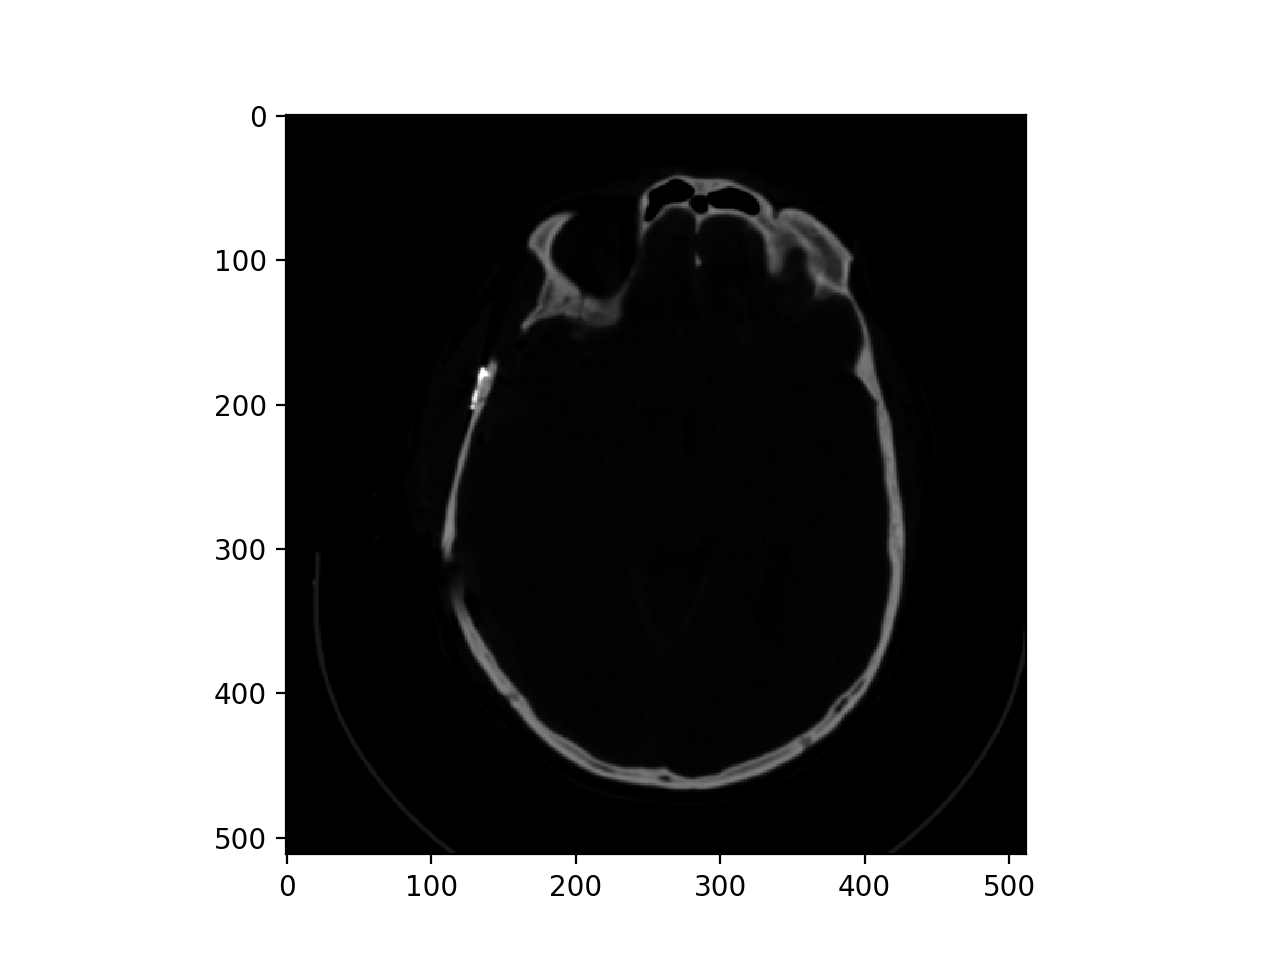

In [29]:
%matplotlib nbagg
plt.imshow(array1[:,:,50], cmap='gray')
plt.show()
plt.ion()

# 2. Remove Skull

In [13]:
skin_mask = array
skin_mask = np.multiply(skin_mask, (array>-200).astype(int))
array1 = np.multiply(skin_mask, (skin_mask>0.0).astype(int))
array1 = np.multiply(array1, (array1>-200).astype(int))
skull_mask = array1>84.0
array2 = np.multiply(array1, (array1<84.0).astype(int))
orbital_mask = skull_mask
for i in range(5):
    orbital_mask = bd(skull_mask)
array3 = np.multiply(array2, (orbital_mask==False).astype(int))
array4 = np.multiply(array3, (array3>0.0).astype(int))
import nipype.interfaces.fsl as fsl

def extract(thresholded):
    img = nib.Nifti1Image(thresholded, np.eye(4))
    nib.save(img, 'temp.nii.gz')
    img = nib.load('temp.nii.gz')
    mybet = fsl.BET()
    result = mybet.run(in_file='temp.nii.gz', out_file='BET-temp.nii.gz', frac=0.1)
    img = nib.load('BET-temp.nii.gz')
    data = img.get_data()
    return data
array5 = extract(array4)
brain_mask = np.multiply(bc(bfh(bd(array5))).astype(int), array5)
B_mask = (brain_mask!=0).astype(int)


# 3. Remove Orbital Region

# 4. Eliminate Cerebral Ventricle 

# 5. Cannot Create Dmap

<IPython.core.display.Javascript object>


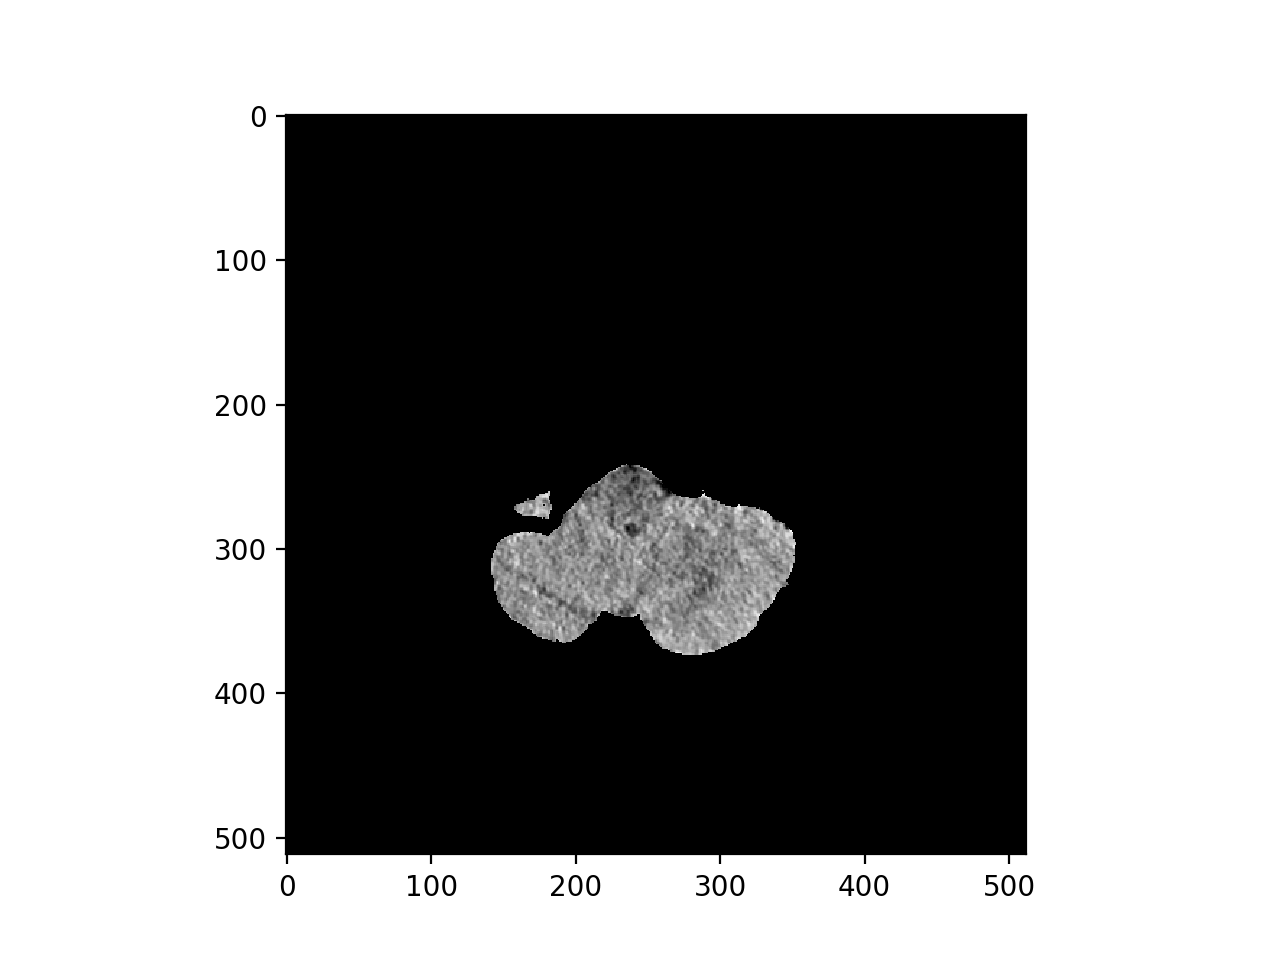

In [21]:
%matplotlib nbagg
plt.imshow(brain_mask[:,:,50], cmap='gray')
plt.show()
plt.ion()

# 6. Get Ventricles

In [23]:
ventr_mask1 = np.multiply((brain_mask>0).astype(int), (brain_mask<22).astype(int))

In [24]:
ventr_mask2 = bd(ventr_mask1)

In [25]:
ventr_mask3 = be(ventr_mask2)

In [26]:
ventr_mask4 = bd(ventr_mask3)

In [28]:
import skimage

ventr_loop = ventr_mask3

for i in range(4):
    labels = skimage.measure.label(ventr_loop, connectivity=3)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = v.index(max(v))
    vcoords = props[ind].coords
    ventr_loop = np.zeros((array.shape))
    for i in range(len(vcoords)):
        a,b,c = vcoords[i]
        ventr_loop[a,b,c]=1
    ventr_loop = bd(be(bd(be(ventr_loop))))

In [29]:
v_mask = bfh(ventr_loop)
mask = v_mask.astype(np.float64)
# mask = np.swapaxes(mask, 0, 1)
# mask = np.swapaxes(mask, 0, 2)

<IPython.core.display.Javascript object>


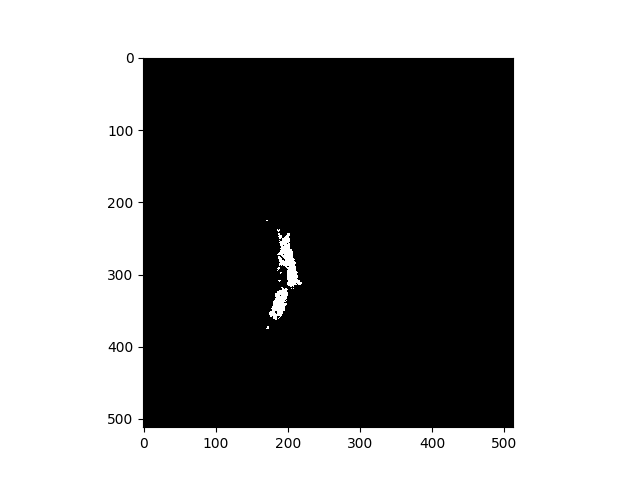

In [206]:
% matplotlib nbagg
plt.imshow(ventr_loop[:,:,150], cmap='gray')
plt.show()
plt.ion()

In [207]:
v_mask = ventr_loop

In [232]:
mask = v_mask.astype(np.float64)
mask = np.swapaxes(mask, 0, 1)
mask = np.swapaxes(mask, 0, 2)

img = sitk.GetImageFromArray(mask)
sampleimg = sitk.ReadImage(path)
img.SetDirection(sampleimg.GetDirection())
if not path.endswith('.dcm'):
    origin = sampleimg.GetOrigin()
img.SetOrigin(origin)
img.SetSpacing(ConstPixelSpacing)
midplaneMaskPath = os.path.join(os.path.split(path)[0], 'vmask.mha')
sitk.WriteImage(img, midplaneMaskPath)

# 7. Get Haematoma

In [210]:
h_mask = (array5>50.0).astype(float)*1000
array6 = np.multiply(brain_mask, h_mask)
array7 = be(array6)
array8 = bc((array7))
array9 = bfh((array8))
array10 = bd(bd((array8)))
array11 = bfh(bd(array10))

In [218]:
import skimage

h_loop = array11

for i in range(4):
    labels = skimage.measure.label(h_loop, connectivity=3)
    props = skimage.measure.regionprops(labels)
    h = [p.area for p in props]
    ind = h.index(max(h))
    hcoords = props[ind].coords
    h_loop = np.zeros((array.shape))
    for i in range(len(hcoords)):
        a,b,c = hcoords[i]
        h_loop[a,b,c]=1
    h_loop = bd(be(bd(be(h_loop))))

0
0
[[135 231 149]
 [135 232 149]
 [135 233 149]
 ..., 
 [478 205 111]
 [478 206 105]
 [478 206 108]]
1
0
[[135 231 149]
 [135 232 149]
 [135 233 149]
 ..., 
 [478 205 111]
 [478 206 105]
 [478 206 108]]
2
0
[[135 231 149]
 [135 232 149]
 [135 233 149]
 ..., 
 [478 205 111]
 [478 206 105]
 [478 206 108]]
3
0
[[135 231 149]
 [135 232 149]
 [135 233 149]
 ..., 
 [478 205 111]
 [478 206 105]
 [478 206 108]]


In [229]:
h_mask = h_loop

In [231]:
mask = h_mask.astype(np.float64)
mask = np.swapaxes(mask, 0, 1)
mask = np.swapaxes(mask, 0, 2)

img = sitk.GetImageFromArray(mask)
sampleimg = sitk.ReadImage(path)
img.SetDirection(sampleimg.GetDirection())
if not path.endswith('.dcm'):
    origin = sampleimg.GetOrigin()
img.SetOrigin(origin)
img.SetSpacing(ConstPixelSpacing)
midplaneMaskPath = os.path.join(os.path.split(path)[0], 'hmask.mha')
sitk.WriteImage(img, midplaneMaskPath)

# 8. Volumes Analysis

In [223]:
planes = np.load('/Volumes/SINEADUSB/Scans/planes-params.npy')
plane = planes[pathnumber]

In [224]:
a,b,c,d = plane[1:].astype(np.float64)

In [233]:
shape = array.shape
midplane_split = np.zeros(shape)
for k in range(shape[2]):
    x = np.arange(0,shape[0],1)
    z = np.linspace(0,shape[2],shape[0])
    xx, yy = np.meshgrid(z, (d-c*z-a*x)/b)
    y = yy.astype(int)
    for j in range(len(y)):
        midplane_split[y[k,j]:shape[0],:, k]=1

In [234]:
v_mask = (v_mask).astype(int)

In [235]:
%matplotlib nbagg
left_h = np.multiply(h_mask, midplane_split==0)
right_h = np.multiply(h_mask, midplane_split==1)

left_v = np.multiply(v_mask, midplane_split==0)
right_v = np.multiply(v_mask, midplane_split==1)

brain = np.multiply(brain_mask, (h_mask==0).astype(int)) # no haematoma

left_brain = np.multiply(brain, midplane_split==0)
right_brain = np.multiply(brain, midplane_split==1)

# 9. Ventricle Analysis


In [236]:
brainArea = []
for i in range(brain_mask.shape[2]):
    brainArea.append(np.count_nonzero(brain_mask[:,:,i]))
midsliceIndex = np.argmax(brainArea)

In [237]:
# check that there is ventricle at the midsliceIndex

if (np.nonzero(h_mask[:,:,midsliceIndex]) == 0) != False:
    print 'using hArea for '
    vArea = []
    for i in range(brain_mask.shape[2]):
        hArea.append(np.count_nonzero(v_mask[:,:,i]))
    midsliceIndex = np.argmax(vArea)

In [238]:
midsliceIndex

157

286.592957746 194.905164319


<IPython.core.display.Javascript object>


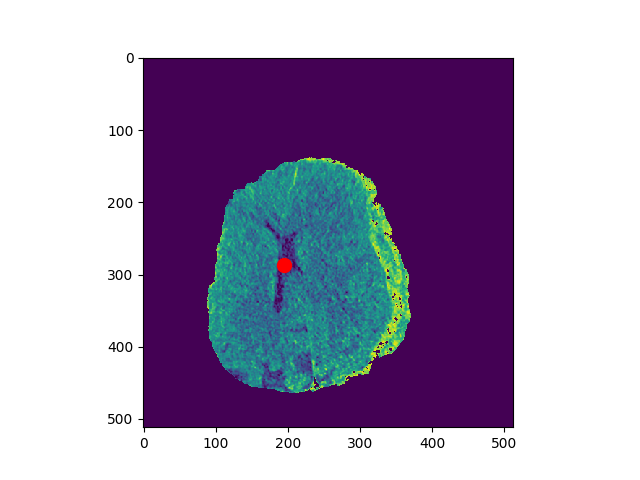

In [239]:
i = midsliceIndex

%matplotlib nbagg

nonzeros = np.nonzero(np.nan_to_num(v_mask[:,:,i]))
w2, w1 = np.mean(nonzeros[0]), np.mean(nonzeros[1])
print w2, w1
# plt.clf()
plt.imshow(brain_mask[:,:,i])
plt.scatter(w1, w2, s=100, c='r')
plt.show()
plt.ion()

In [ ]:
dirname = os.path.split(os.path.dirname(path))[1]

In [ ]:
left_h_vol = (left_h[left_h!=0]).size*np.prod(ConstPixelSpacing)*0.001
right_h_vol = (right_h[right_h!=0]).size*np.prod(ConstPixelSpacing)*0.001
left_brain_vol = (left_brain[left_brain!=0]).size*np.prod(ConstPixelSpacing)*0.001
right_brain_vol = (right_brain[right_brain!=0]).size*np.prod(ConstPixelSpacing)*0.001
left_ventr_vol = (left_v[left_v!=0]).size*np.prod(ConstPixelSpacing)*0.001 
right_ventr_vol = (right_v[right_v!=0]).size*np.prod(ConstPixelSpacing)*0.001 

In [ ]:
print 'Volume of haematoma on LHS is {}'.format(left_h_vol)
print 'Volume of haematoma on RHS is {}'.format(right_h_vol)
print 'Volume of brain on LHS is {}'.format(left_brain_vol)
print 'Volume of brain on RHS is {}'.format(right_brain_vol)
print 'Volume of CSF in ventricles on LHS is {}'.format(left_ventr_vol)
print 'Volume of CSF in ventricles on RHS is {}'.format(right_ventr_vol)

In [ ]:
info.append((dirname, 'w1 = {}'.format(w1), 'w2 = {}'.format(w2), 
             'Volume of haematoma on LHS is {}'.format(left_h_vol),
             'Volume of haematoma on RHS is {}'.format(right_h_vol),
             'Volume of brain on LHS is {}'.format(left_brain_vol),
             'Volume of brain on RHS is {}'.format(right_brain_vol),
             'Volume of CSF in ventricles on LHS is {}'.format(left_ventr_vol),
             'Volume of CSF in ventricles on RHS is {}'.format(right_ventr_vol)))

In [ ]:
info

In [ ]:
# %matplotlib nbagg

# import ipywidgets
# from ipywidgets import interact, fixed
# from scipy import interpolate

# slice_no = 80
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.imshow(data[:,:,slice_no])
# ax.set_xlim([0, data.shape[1]])
# ax.set_ylim([data.shape[0], 0])
# ax.set_title('Drawing a spline onto a slice')
# plt.ion()

# coords = []
# spline = []
# all_spl = []

# def pltspline(spl):
#     global data
#     global ax
#     global fig
#     ax.imshow(data[:,:,80])
#     x = spl[0].astype(int)
#     y = spl[1].astype(int)
#     if len(ax.lines):
#         ax.lines[0].set_xdata(x)
#         ax.lines[0].set_ydata(y)
#     else:
#         ax.plot(x,y, linewidth = 2)
#     fig.canvas.draw()

# def onclick(event):
#     global ix, iy, iz
#     ix, iy, iz = event.xdata, event.ydata, slice_no
#     global coords
#     coords.append((ix, iy, iz))
#     np_coords = np.array(coords)
#     x = np_coords[:,0]
#     y = np_coords[:,1]
#     global tck,u
#     tck, u = interpolate.splprep([x, y], s=0)
#     global spline 
#     spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
#     if len(coords)>0:
#         interact(pltspline, spl=fixed(spline))
#     return None

# print('Click on points to draw a line which marks a boundary for the brain. When finished, click the submit spline button')
# cid = fig.canvas.mpl_connect('button_press_event', onclick)

# from ipywidgets import Button, HBox, VBox

# words = ['Start Over', 'Delete Last Point', 'Submit Spline']
# items = [Button(description=w) for w in words]

# def start_over_clicked(b):

#     global coords
#     coords = []
#     global spline
#     spline = np.array([0,0])
#     interact(pltspline, spl=fixed(spline))
#     return None

# def del_lp_clicked(b):

#     global coords
#     coords = coords[0:-1]
#     np_coords = np.array(coords)
#     if len(coords) > 3:
#         x = np_coords[:,0]
#         y = np_coords[:,1]
#         global tck,u
#         tck, u = interpolate.splprep([x, y], s=0)
#         global spline 
#         spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
#         interact(pltspline, spl=fixed(spline))
#     else:
#         coords = []
#         global spline
#         spline = np.array([0,0])
#         interact(pltspline, spl=fixed(spline))

#     return None

# def submit_spline_clicked(b):
    
#     fig.canvas.mpl_disconnect(cid)
#     print('Spline Submitted')
#     return None
    

# items[0].on_click(start_over_clicked)
# items[1].on_click(del_lp_clicked)
# items[2].on_click(submit_spline_clicked)

# HBox([items[0], items[1], items[2]])

In [ ]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET